## Import Necessary Packages

In [1]:
!pip install transformers
!pip install sentencepiece

In [2]:
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
# from keras.preprocessing.sequence import pad_sequences
import pickle
import os
import numpy as np

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.callbacks import Callback
import tensorflow_hub as hub
import tensorflow as tf
import re

from keras import backend as K
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate, Embedding, Flatten, Activation, SpatialDropout1D
from keras.layers import Bidirectional, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
#from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils
#from keras.engine import Layer
from keras import initializers, regularizers, constraints
from keras.layers import *

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, CuDNNGRU, CuDNNLSTM, Add, Reshape
from keras.layers import MaxPooling1D, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from nltk.tokenize import sent_tokenize, word_tokenize

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Import Original Dataset

In [5]:
train_data = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_train.csv')
val_data   = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv')
test_data = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_test.csv')

In [6]:
train_data

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550147,contradiction,( ( ( ( Four dirty ) and ) ( barefooted childr...,( ( four kids ) ( ( won awards ) ( ( ( for ` )...,(ROOT (NP (NP (CD Four) (NNS dirty)) (CC and) ...,(ROOT (S (NP (CD four) (NNS kids)) (VP (VBD wo...,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2267923837.jpg#3,2267923837.jpg#3r1c,contradiction,NaN,NaN,NaN,NaN
550148,neutral,( ( ( ( Four dirty ) and ) ( barefooted childr...,( ( ( ( ( ( four ( homeless children ) ) ( had...,(ROOT (NP (NP (CD Four) (NNS dirty)) (CC and) ...,(ROOT (S (S (NP (CD four) (JJ homeless) (NNS c...,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",2267923837.jpg#3,2267923837.jpg#3r1n,neutral,NaN,NaN,NaN,NaN
550149,neutral,( ( A man ) ( ( is ( surfing ( in ( ( a bodysu...,( ( ( A man ) ( in ( a bodysuit ) ) ) ( ( is (...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,7979219683.jpg#2,7979219683.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
550150,contradiction,( ( A man ) ( ( is ( surfing ( in ( ( a bodysu...,( ( ( A man ) ( in ( a ( business suit ) ) ) )...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,7979219683.jpg#2,7979219683.jpg#2r1c,contradiction,NaN,NaN,NaN,NaN


In [7]:
val_data

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,4705552913.jpg#2,4705552913.jpg#2r1n,neutral,entailment,neutral,neutral,neutral
1,entailment,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...,Two women are embracing while holding to go pa...,Two woman are holding packages.,4705552913.jpg#2,4705552913.jpg#2r1e,entailment,entailment,entailment,entailment,entailment
2,contradiction,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,4705552913.jpg#2,4705552913.jpg#2r1c,contradiction,contradiction,contradiction,contradiction,contradiction
3,entailment,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1e,entailment,entailment,entailment,entailment,entailment
4,neutral,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1n,neutral,neutral,neutral,entailment,entailment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-,( ( ( A ( small girl ) ) ( wearing ( a ( pink ...,( ( The girl ) ( ( is ( sitting ( on ( ( a ( c...,(ROOT (S (NP (NP (DT A) (JJ small) (NN girl)) ...,(ROOT (S (NP (DT The) (NN girl)) (VP (VBZ is) ...,A small girl wearing a pink jacket is riding o...,The girl is sitting on a carved horse made of ...,77063034.jpg#3,77063034.jpg#3r1n,neutral,contradiction,entailment,contradiction,NaN
9996,contradiction,( ( ( A ( small girl ) ) ( wearing ( a ( pink ...,( ( The girl ) ( ( is ( moving ( at ( ( the sp...,(ROOT (S (NP (NP (DT A) (JJ small) (NN girl)) ...,(ROOT (S (NP (DT The) (NN girl)) (VP (VBZ is) ...,A small girl wearing a pink jacket is riding o...,The girl is moving at the speed of light.,77063034.jpg#3,77063034.jpg#3r1c,contradiction,contradiction,contradiction,contradiction,contradiction
9997,entailment,( ( ( A ( young girl ) ) ( with ( ( ( ( ( ( bl...,( People ( in ( a ( water fountain ) ) ) ),(ROOT (NP (NP (DT A) (JJ young) (NN girl)) (PP...,(ROOT (NP (NP (NNS People)) (PP (IN in) (NP (D...,A young girl with blue and pink ribbons in her...,People in a water fountain,4805835848.jpg#0,4805835848.jpg#0r1e,entailment,entailment,entailment,entailment,entailment
9998,contradiction,( ( ( A ( young girl ) ) ( with ( ( ( ( ( ( bl...,( ( ( A ( young girl ) ) knits ) ( a sweater ) ),(ROOT (NP (NP (DT A) (JJ young) (NN girl)) (PP...,(ROOT (NP (NP (DT A) (JJ young) (NN girl)) (NP...,A young girl with blue and pink ribbons in her...,A young girl knits a sweater,4805835848.jpg#0,4805835848.jpg#0r1c,contradiction,contradiction,entailment,contradiction,neutral


In [8]:
test_data

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( has ( cracks ( in ( the c...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ ha...,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,2677109430.jpg#1,2677109430.jpg#1r1n,neutral,contradiction,contradiction,neutral,neutral
1,entailment,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( is ( filled ( with song )...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is...,This church choir sings to the masses as they ...,The church is filled with song.,2677109430.jpg#1,2677109430.jpg#1r1e,entailment,entailment,entailment,neutral,entailment
2,contradiction,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( ( A choir ) ( singing ( at ( a ( baseball ...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG sing...,This church choir sings to the masses as they ...,A choir singing at a baseball game.,2677109430.jpg#1,2677109430.jpg#1r1c,contradiction,contradiction,contradiction,contradiction,contradiction
3,neutral,( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,( ( The woman ) ( ( is young ) . ) ),(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...,"A woman with a green headscarf, blue shirt and...",The woman is young.,6160193920.jpg#4,6160193920.jpg#4r1n,neutral,neutral,neutral,neutral,neutral
4,entailment,( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,( ( The woman ) ( ( is ( very happy ) ) . ) ),(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,6160193920.jpg#4,6160193920.jpg#4r1e,entailment,entailment,contradiction,entailment,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,contradiction,( ( Two women ) ( ( are ( ( observing somethin...,( ( ( Two women ) ( are ( standing ( with ( th...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (NP (CD Two) (NNS women)) (SBAR (...,Two women are observing something together.,Two women are standing with their eyes closed.,4378810163.jpg#4,4378810163.jpg#4r1c,contradiction,contradiction,contradiction,contradiction,contradiction
9996,entailment,( ( Two women ) ( ( are ( ( observing somethin...,( ( Two girls ) ( ( are ( looking ( at somethi...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (CD Two) (NNS girls)) (VP (VBP ar...,Two women are observing something together.,Two girls are looking at something.,4378810163.jpg#4,4378810163.jpg#4r1e,entailment,entailment,entailment,contradiction,entailment
9997,contradiction,( ( ( ( ( A man ) ( in ( a ( black ( leather j...,( ( A man ) ( ( is ( flying ( a kite ) ) ) . ) ),(ROOT (S (NP (NP (NP (DT A) (NN man)) (PP (IN ...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,A man in a black leather jacket and a book in ...,A man is flying a kite.,152881593.jpg#1,152881593.jpg#1r1c,contradiction,contradiction,contradiction,contradiction,contradiction
9998,entailment,( ( ( ( ( A man ) ( in ( a ( black ( leather j...,( ( A man ) ( ( is ( speaking ( in ( a classro...,(ROOT (S (NP (NP (NP (DT A) (NN man)) (PP (IN ...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,A man in a black leather jacket and a book in ...,A man is speaking in a classroom.,152881593.jpg#1,152881593.jpg#1r1e,entailment,entailment,entailment,neutral,entailment


In [9]:
print("Training on", train_data.shape[0], "examples")
print("Validating on", test_data.shape[0], "examples")
print("Testing on", val_data.shape[0], "examples")

Training on 550152 examples
Validating on 10000 examples
Testing on 10000 examples


## Check the Null Value

In [10]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())
print(val_data.isnull().sum())

gold_label                     0
sentence1_binary_parse         0
sentence2_binary_parse         6
sentence1_parse                0
sentence2_parse                0
sentence1                      0
sentence2                      6
captionID                      0
pairID                         0
label1                         0
label2                    510782
label3                    510757
label4                    510769
label5                    513238
dtype: int64
gold_label                 0
sentence1_binary_parse     0
sentence2_binary_parse     0
sentence1_parse            0
sentence2_parse            0
sentence1                  0
sentence2                  0
captionID                  0
pairID                     0
label1                     0
label2                     0
label3                     0
label4                     0
label5                    10
dtype: int64
gold_label                 0
sentence1_binary_parse     0
sentence2_binary_parse     0
sentence1_parse    

<AxesSubplot:>

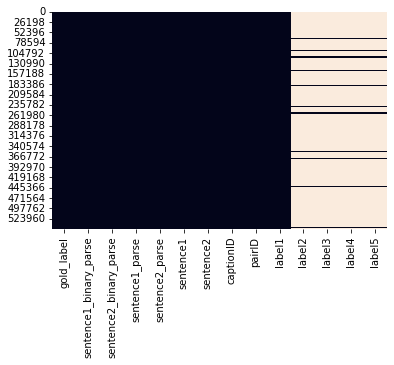

In [11]:
import seaborn as sns

sns.heatmap(train_data.isnull(), cbar=False)

<AxesSubplot:>

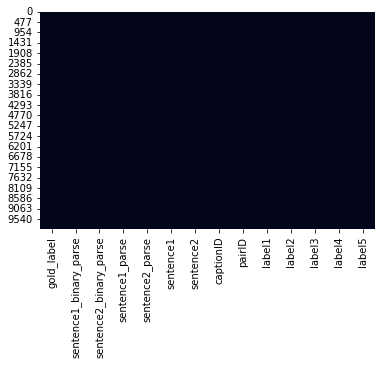

In [12]:
sns.heatmap(test_data.isnull(), cbar=False)

<AxesSubplot:>

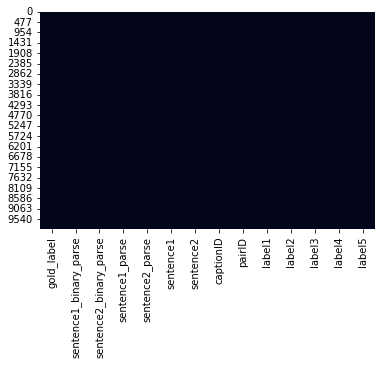

In [13]:
sns.heatmap(val_data.isnull(), cbar=False)

In [15]:
print("Train Target Distribution")
print(train_data.gold_label.value_counts())

Train Target Distribution
entailment       183416
contradiction    183187
neutral          182764
-                   785
Name: gold_label, dtype: int64


In [18]:
print("Validation Target Distribution")
print(val_data.gold_label.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: gold_label, dtype: int64


In [19]:
print("Test Target Distribution")
print(test_data.gold_label.value_counts())

Test Target Distribution
entailment       3368
contradiction    3237
neutral          3219
-                 176
Name: gold_label, dtype: int64


## Remove Null Values

In [20]:
train_data = train_data.dropna(subset = ['sentence2'])

train_data = train_data[train_data["gold_label"] != "-"]
test_data = test_data[test_data["gold_label"] != "-"]
val_data = val_data[val_data["gold_label"] != "-"]

In [21]:
train_data['sentence1'] = train_data['sentence1'].astype(str)
train_data['sentence2'] = train_data['sentence2'].astype(str)

val_data['sentence1'] = val_data['sentence1'].astype(str)
val_data['sentence2'] = val_data['sentence2'].astype(str)

test_data['sentence1'] = test_data['sentence1'].astype(str)
test_data['sentence2'] = test_data['sentence2'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [23]:
train_data[(train_data['sentence1'] == '') | (train_data['sentence2'] == '')]

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5


In [26]:
train_df = train_data.loc[:100000,['sentence1','sentence2','gold_label']]
train_df.shape

(99888, 3)

In [28]:
val_df = val_data.loc[:,['sentence1','sentence2','gold_label']]
val_df.shape

(9842, 3)

In [29]:
test_df = test_data.loc[:,['sentence1','sentence2','gold_label']]
test_df.shape

(9824, 3)

### There are also some sentences containing only a meaningless word, so we remove them

In [27]:
train_df[(train_df['sentence1'].str.split().str.len() == 1) | (train_df['sentence2'].str.split().str.len() == 1)]

,sentence1,sentence2,gold_label
37767,Brown dog with objest in mouth moving toward c...,Fetch.,entailment
37768,Brown dog with objest in mouth moving toward c...,Feltch.,contradiction
88117,A guy in a blue suite kicking his leg.,https://www.youtube.com/watch?v=tXrsvC25GH8,contradiction
91475,"Two people are on a stage, one holding a micro...",The,contradiction


In [30]:
train_df = train_df[(train_df['sentence1'].str.split().str.len() > 1) & (train_df['sentence2'].str.split().str.len() > 1)]
val_df = val_df[(val_df['sentence1'].str.split().str.len() > 1) & (val_df['sentence2'].str.split().str.len() > 1)]
test_df = test_df[(test_df['sentence1'].str.split().str.len() > 1) & (test_df['sentence2'].str.split().str.len() > 1)]

In [31]:
train_df[(train_df['sentence1'].str.split().str.len() == 1) | (train_df['sentence2'].str.split().str.len() == 1)]

,sentence1,sentence2,gold_label


## Create function to decontract Short Form Words

In [32]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from string import punctuation

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
def clean_text(text, stop_words = False, lemmatization = False):
    #text = text.lower().split()
    if stop_words:
        stop = stopwords.words('english')
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
  
    #text = " ".join(text)
    #text = re.sub("[^A-Za-z']+", ' ', str(text)).replace("'", '')
    text = re.sub(r"\bum*\b", "", text)
    text = re.sub(r"\buh*\b", "", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])
    #text = text.translate(str.maketrans('', '', punctuation))
    
    return text

In [38]:
train_df['sentence1'] = train_df['sentence1'].apply(lambda text: clean_text(text))
train_df['sentence2'] = train_df['sentence2'].apply(lambda text: clean_text(text))
val_df['sentence1'] = val_df['sentence1'].apply(lambda text: clean_text(text))
val_df['sentence2'] = val_df['sentence2'].apply(lambda text: clean_text(text))

In [39]:
train_df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [41]:
val_df.head()

,sentence1,sentence2,gold_label
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,neutral
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,entailment
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,contradiction
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,entailment
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,neutral


## Exploratory Data Analysis

In [42]:
train_textlength = train_df.copy()

In [43]:
train_textlength['text_length1'] = [len(x) for x in train_textlength['sentence1'].str.split(' ')]
train_textlength['text_length2'] = [len(y) for y in train_textlength['sentence2'].str.split(' ')]

In [44]:
train_textlength.head()

,sentence1,sentence2,gold_label,text_length1,text_length2
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral,11,9
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction,11,9
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment,11,7
3,Children smiling and waving at camera,They are smiling at their parents,neutral,6,6
4,Children smiling and waving at camera,There are children present,entailment,6,4


In [45]:
# text length statistics grouped by label
train_textlength['text_length1'].groupby(train_textlength['gold_label']).describe()

,count,mean,std,min,25%,50%,75%,max
gold_label,,,,,,,,
contradiction,33308.0,12.792843,5.674926,2.0,9.0,12.0,16.0,78.0
entailment,33383.0,12.795764,5.677600,2.0,9.0,12.0,16.0,78.0
neutral,33193.0,12.799446,5.685541,2.0,9.0,12.0,16.0,78.0


In [46]:
train_textlength['text_length2'].groupby(train_textlength['gold_label']).describe()

,count,mean,std,min,25%,50%,75%,max
gold_label,,,,,,,,
contradiction,33308.0,7.345803,2.794828,2.0,6.0,7.0,9.0,35.0
entailment,33383.0,6.603720,2.732621,2.0,5.0,6.0,8.0,43.0
neutral,33193.0,8.248456,3.381236,2.0,6.0,8.0,10.0,38.0


In [48]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'Label')

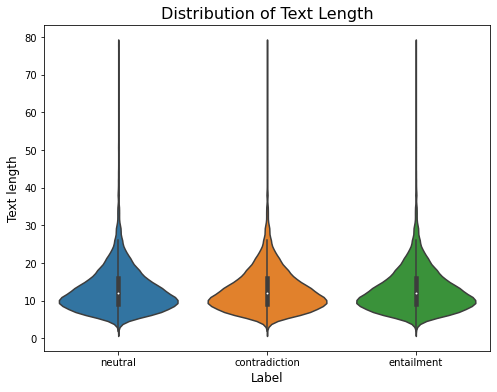

In [49]:
# Plot distribution of review length
plt.figure(figsize = (8,6))
sns.violinplot(x='gold_label', y='text_length1', data=train_textlength)

# Plot formatting
plt.title('Distribution of Text Length', size=16)
plt.ylabel("Text length", size=12)
plt.xlabel("Label", size=12)

Text(0.5, 0, 'Label')

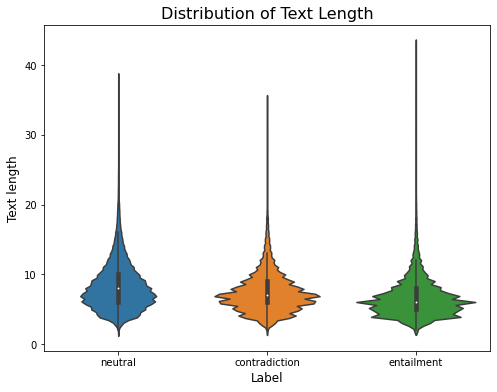

In [50]:
# Plot distribution of review length
plt.figure(figsize = (8,6))
sns.violinplot(x='gold_label', y='text_length2', data=train_textlength)

# Plot formatting
plt.title('Distribution of Text Length', size=16)
plt.ylabel("Text length", size=12)
plt.xlabel("Label", size=12)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='gold_label', ylabel='count'>

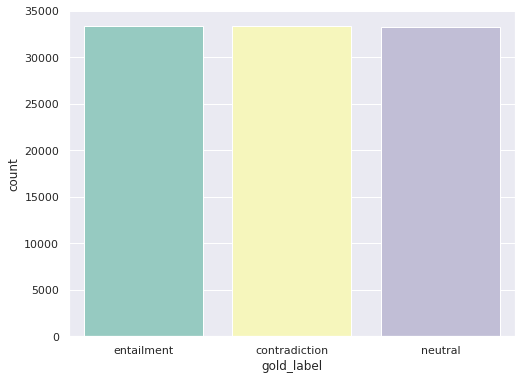

In [51]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,6)})

sns.countplot(train_textlength['gold_label'],order=train_textlength['gold_label'].value_counts().index,palette='Set3')